# Imports

In [1]:
import os
import json
import pickle
import tarfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

from utils import *

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Define Helper Functions

In [3]:
# define a function to save the feature vector dictionary to disk
def load_feature_data(vectors_filepath, names_filepath):
    
    # extract the JSON file from the tar.gz file
    with tarfile.open(vectors_filepath, 'r:gz') as tar:
        tar.extractall()
        json_filename = tar.getnames()[0]  # assuming only one file in the archive
    
    # load the JSON file and convert Python lists back to numpy arrays
    with open(json_filename, 'r') as f:
        feature_vectors_dict = json.load(f)
    
    feature_vectors = {}
    for class_name, vectors in feature_vectors_dict.items():
        feature_vectors[class_name] = [np.array(vector) for vector in vectors]
    
    # remove the extracted JSON file
    os.remove(json_filename)
    
    # load feature names
    with open(names_filepath, 'rb') as f:
        feature_names = pickle.load(f)
        
    return feature_vectors, feature_names

In [4]:
# define a function to visualize the PCA elbow plot
def evaluate_pca(pca):
    
    # compute the cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # plot the elbow plot
    plt.figure(figsize=(5, 3))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative % of Variation Explained')
    plt.title('Principal Component Elbow Plot')
    plt.grid(True)
    
    # find the location of inflection point
    # NOTE: this is used to determine the best number of PC's
    diff = np.diff(cumulative_variance)
    inflection_point = np.argmax(diff < np.mean(diff))
    plt.axvline(x=inflection_point + 1, color='r', linestyle='--')
    plt.axhline(y=cumulative_variance[inflection_point], color='r', linestyle='--')
    
    # add label to indicate inflection point
    plt.text(inflection_point + 50, cumulative_variance[inflection_point] - .2,
            f"n_components={inflection_point + 1}\ncum_%_variation={cumulative_variance[inflection_point]*100:.2f}%", color='r', fontsize=10)

    plt.show()
    
    return inflection_point + 1
    

In [5]:
# define a function to display the main features that contribute to a set of top PC's
def display_loadings(pca, n_pc=5, n_features=10):
    
    # extract top principal components
    top_components = pca.components_[:n_pc]

    # create dataframes for top principal components
    for i, component in enumerate(top_components):
        loading_scores = pd.DataFrame({'feature_name': feature_names, 'loading_score': component})
        loading_scores = loading_scores.sort_values(by='loading_score', ascending=False).head(n_features)
        print(f"Top {n_features} features for Principal Component {i + 1}:")
        display(loading_scores)

# Load data

In [6]:
# define file directory
directory = '../data/interim/PatternNet/PatternNet/images'

# create a list of classes considered for this project
classes = ['beach', 'chaparral', 'dense_residential', 'forest', 'freeway', 'harbor', 'overpass', 'parking_space', 'river', 'swimming_pool']

In [7]:
# load feature data from disk
feature_vectors_train, feature_names = load_feature_data("../data/processed/feature_vectors_train.tar.gz", "../data/processed/feature_names.pkl")
feature_vectors_val, feature_names = load_feature_data("../data/processed/feature_vectors_val.tar.gz", "../data/processed/feature_names.pkl")
feature_vectors_test, feature_names = load_feature_data("../data/processed/feature_vectors_test.tar.gz", "../data/processed/feature_names.pkl")


In [8]:
# inspections
print(type(feature_vectors_train))
print(feature_vectors_train.keys())
print(type(feature_vectors_train['beach']))
print(len(feature_vectors_train['beach']))
print(type(feature_vectors_train['beach'][0]))
print(len(feature_vectors_train['beach'][0]))
print(feature_vectors_train['beach'][0])

<class 'dict'>
dict_keys(['parking_space', 'beach', 'forest', 'overpass', 'river', 'dense_residential', 'swimming_pool', 'chaparral', 'freeway', 'harbor'])
<class 'list'>
479
<class 'numpy.ndarray'>
116
[1.13955765e+02 1.27463531e+02 1.19847519e+02 2.25198862e+01
 2.18036206e+01 2.29220558e+01 0.00000000e+00 1.00000000e+00
 2.30000000e+01 5.35000000e+02 9.58400000e+03 2.71660000e+04
 2.72750000e+04 9.49000000e+02 3.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.83000000e+02 2.43790000e+04
 3.38480000e+04 6.51400000e+03 3.15000000e+02 3.60000000e+01
 1.60000000e+01 1.30000000e+01 7.00000000e+00 4.00000000e+00
 3.00000000e+00 2.00000000e+00 3.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 2.00000000e+00 2.00000000e+00
 0.00000000e+00 8.00000000e+00 1.50000000e+01 2.00000000e+01
 2.40000000e+01 3.90000000e+01 2.90000000e+01 1.09000000e+02
 4.2

# Transform data

In [9]:
# flatten feature vectors and prepare data for PCA
X = []
for class_name in classes:
    X.extend(feature_vectors_train[class_name])
X = np.array(X)
print(X.shape)

# standardize data
features_scaler = StandardScaler()
X = features_scaler.fit_transform(X)

# save the standardization scaler to disk
with open("../data/processed/features_scaler.pkl", 'wb') as f:
    pickle.dump(features_scaler, f)

(4799, 116)


# Principal Component Analysis

In [10]:
# perform PCA
pca_model = PCA()
pca_model.fit(X)

PCA()

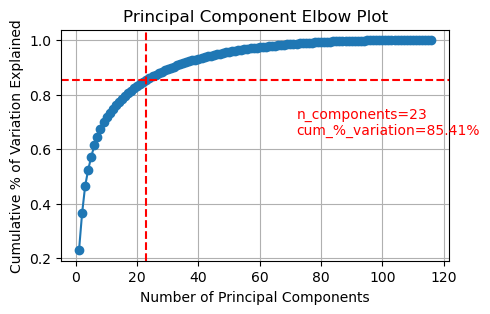

In [11]:
n_pc_components = evaluate_pca(pca_model)

In [12]:
display_loadings(pca_model, n_pc=20, n_features=5)

Top 5 features for Principal Component 1:


,feature_name,loading_score
67,dissimilarity_mean,0.182042
87,freqbin_16,0.175191
86,freqbin_15,0.173827
85,freqbin_14,0.166583
88,freqbin_17,0.165801


Top 5 features for Principal Component 2:


,feature_name,loading_score
79,freqbin_8,0.208294
47,v_2,0.169422
48,v_3,0.164290
78,freqbin_7,0.161282
46,v_1,0.143804


Top 5 features for Principal Component 3:


,feature_name,loading_score
3,r_std,0.208720
4,g_std,0.196704
107,sift_bow_11,0.192850
26,s_1,0.189859
105,sift_bow_9,0.188439


Top 5 features for Principal Component 4:


,feature_name,loading_score
69,energy_mean,0.216077
72,freqbin_1,0.197708
73,freqbin_2,0.196489
49,v_4,0.193740
68,homogeneity_mean,0.188582


Top 5 features for Principal Component 5:


,feature_name,loading_score
11,h_6,0.212525
46,v_1,0.209068
39,s_14,0.198316
36,s_11,0.188961
37,s_12,0.187887


Top 5 features for Principal Component 6:


,feature_name,loading_score
18,h_13,0.232468
104,sift_bow_8,0.205756
16,h_11,0.199649
72,freqbin_1,0.195249
71,freqbin_0,0.192224


Top 5 features for Principal Component 7:


,feature_name,loading_score
52,v_7,0.233271
16,h_11,0.200942
18,h_13,0.195353
17,h_12,0.184405
13,h_8,0.178388


Top 5 features for Principal Component 8:


,feature_name,loading_score
62,v_17,0.204496
104,sift_bow_8,0.190644
63,v_18,0.184554
26,s_1,0.184169
7,h_2,0.173188


Top 5 features for Principal Component 9:


,feature_name,loading_score
55,v_10,0.194142
54,v_9,0.177899
56,v_11,0.175286
8,h_3,0.143173
27,s_2,0.136120


Top 5 features for Principal Component 10:


,feature_name,loading_score
15,h_10,0.246240
17,h_12,0.207407
16,h_11,0.205673
34,s_9,0.195423
33,s_8,0.155879


Top 5 features for Principal Component 11:


,feature_name,loading_score
63,v_18,0.258642
15,h_10,0.257986
64,v_19,0.257003
93,freqbin_22,0.204346
13,h_8,0.200195


Top 5 features for Principal Component 12:


,feature_name,loading_score
94,freqbin_23,0.221561
29,s_4,0.220455
64,v_19,0.201569
63,v_18,0.187885
10,h_5,0.184106


Top 5 features for Principal Component 13:


,feature_name,loading_score
93,freqbin_22,0.376219
7,h_2,0.215625
30,s_5,0.196676
56,v_11,0.188771
20,h_15,0.179136


Top 5 features for Principal Component 14:


,feature_name,loading_score
53,v_8,0.392426
20,h_15,0.350005
52,v_7,0.247966
54,v_9,0.239017
38,s_13,0.180423


Top 5 features for Principal Component 15:


,feature_name,loading_score
34,s_9,0.201730
35,s_10,0.189619
12,h_7,0.175058
64,v_19,0.173359
19,h_14,0.160824


Top 5 features for Principal Component 16:


,feature_name,loading_score
95,freqbin_24,0.252869
10,h_5,0.250825
92,freqbin_21,0.242096
11,h_6,0.233090
93,freqbin_22,0.209196


Top 5 features for Principal Component 17:


,feature_name,loading_score
20,h_15,0.650011
57,v_12,0.249679
94,freqbin_23,0.236679
38,s_13,0.215392
58,v_13,0.174951


Top 5 features for Principal Component 18:


,feature_name,loading_score
64,v_19,0.298314
94,freqbin_23,0.276632
65,v_20,0.260499
32,s_7,0.223062
54,v_9,0.131886


Top 5 features for Principal Component 19:


,feature_name,loading_score
94,freqbin_23,0.224365
93,freqbin_22,0.222180
12,h_7,0.217904
35,s_10,0.189061
62,v_17,0.176566


Top 5 features for Principal Component 20:


,feature_name,loading_score
95,freqbin_24,0.404906
50,v_5,0.188106
28,s_3,0.177177
55,v_10,0.168843
20,h_15,0.152277


In [13]:
# re-compute pca model with optimum number of PC's
pca_model = PCA(n_components=n_pc_components)
pca_model.fit(X)

# save the pca model to disk
with open("../data/processed/pca_model.pkl", 'wb') as f:
    pickle.dump(pca_model, f)

# tSNE Visualization

In [14]:
# load class color map from pickle file
with open('../data/processed/eda_class_color_mapping.pkl', 'rb') as f:
    class_color_mapping= pickle.load(f)

In [15]:
# compress data based on PCA model
pc_vectors_train = pca_model.transform(X)

# initialize tSNE with desired parameters
tsne = TSNE(n_components=2)

# fit and transform the data using t-SNE
tsne_data = tsne.fit_transform(pc_vectors_train)

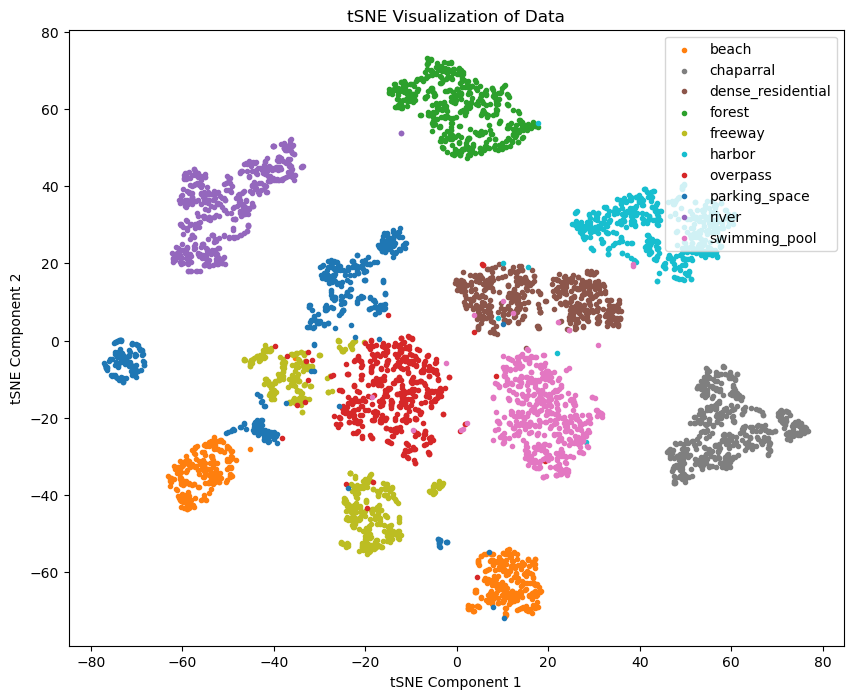

In [16]:
# visualize clustering of train pc's with color-coded classes using loaded class color mapping
plt.figure(figsize=(10, 8))
start_idx = 0
for class_name in classes:
    end_idx = start_idx + len(feature_vectors_train[class_name])
    class_color = class_color_mapping[class_name]
    plt.scatter(tsne_data[start_idx:end_idx, 0], tsne_data[start_idx:end_idx, 1], marker='.', color=class_color, label=class_name)
    start_idx = end_idx
plt.title('tSNE Visualization of Data')
plt.xlabel('tSNE Component 1')
plt.ylabel('tSNE Component 2')
plt.legend()
plt.show()
